In [23]:
import tushare as ts
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
pro = ts.pro_api('cbf6f80f4b52edeb90f58193ceb6d578dde99e802322d039d4089f5a')
df = pro.trade_cal(exchange='', start_date='20180901', end_date='20181001', fields='exchange,cal_date,is_open,pretrade_date', is_open='0')
print(df)

   exchange  cal_date  is_open pretrade_date
0       SSE  20180901        0      20180831
1       SSE  20180902        0      20180831
2       SSE  20180908        0      20180907
3       SSE  20180909        0      20180907
4       SSE  20180915        0      20180914
5       SSE  20180916        0      20180914
6       SSE  20180922        0      20180921
7       SSE  20180923        0      20180921
8       SSE  20180924        0      20180921
9       SSE  20180929        0      20180928
10      SSE  20180930        0      20180928
11      SSE  20181001        0      20180928


In [14]:
df1 = ts.get_hist_data('sz')
print(df1)
df1 = df1.reindex(index = df1.index[::-1])
df1.to_csv('./sz_daily.csv')

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
                open      high     close       low       volume  price_change  \
date                                                                            
2020-09-09  13107.98  13122.76  12861.75  12778.43  637182208.0       -431.58   
2020-09-08  13315.15  13351.57  13293.33  13118.94  534063552.0          9.30   
2020-09-07  13633.51  13714.32  13284.03  13232.24  541636096.0       -372.63   
2020-09-04  13501.91  13680.06  13656.66  13487.69  437114880.0       -115.71   
2020-09-03  13871.27  13933.42  13772.37  13722.58  482940160.0       -115.06   
...              ...       ...       ...       ...          ...           ...   
2018-03-16  11166.43  11192.36  11051.12  11051.12  169598352.0       -112.53   
2018-03-15  11100.53  11195.94  11163.65  11051.62  187573552.0         24.02   
2018-03-14  11198.77  11242.30  11139.63  11138.39  196067744.0       -101.78   
2018-03-13  11311.04  11335.30  11241.41  11236.38  2278

In [15]:
df1['macd'], df1['dea'], df1['hist'] = ta.MACD(df1['close'])
#print(df1['macd'])

In [16]:
df1['date'] = df1.index
#df1['year_month_day'] = df1['date'].apply(lambda x : x.strftime('%Y-%m-%d'))
df1['df_index'] = range(df1.shape[0])
df1 = df1.set_index('df_index')
df1.head

<bound method NDFrame.head of               open      high     close       low       volume  price_change  \
df_index                                                                      
0         11266.32  11328.77  11326.27  11260.46  261773248.0        131.36   
1         11311.04  11335.30  11241.41  11236.38  227848416.0        -84.86   
2         11198.77  11242.30  11139.63  11138.39  196067744.0       -101.78   
3         11100.53  11195.94  11163.65  11051.62  187573552.0         24.02   
4         11166.43  11192.36  11051.12  11051.12  169598352.0       -112.53   
...            ...       ...       ...       ...          ...           ...   
607       13871.27  13933.42  13772.37  13722.58  482940160.0       -115.06   
608       13501.91  13680.06  13656.66  13487.69  437114880.0       -115.71   
609       13633.51  13714.32  13284.03  13232.24  541636096.0       -372.63   
610       13315.15  13351.57  13293.33  13118.94  534063552.0          9.30   
611       13107.98  13

In [17]:
def is_buytime(dataframe,idx):
    if idx-3>0:
        if dataframe.loc[idx-3,'hist'] > dataframe.loc[idx-2,'hist'] and dataframe.loc[idx-2,'hist'] < dataframe.loc[idx-1,'hist'] < dataframe.loc[idx,'hist'] :
            return True
    return False
print(is_buytime(df1,3))

def is_selltime(dataframe,idx):
    if idx-3>0:
        if dataframe.loc[idx-3,'hist'] < dataframe.loc[idx-2,'hist'] and dataframe.loc[idx-2,'hist'] > dataframe.loc[idx-1,'hist'] and dataframe.loc[idx-1,'hist'] > dataframe.loc[idx,'hist']:
            return True
    return False
print(is_selltime(df1,3))

def daily_action(dataframe,idx,share,cash,br,sr):
    if is_buytime(dataframe,idx):
        if cash > 0 and idx >242:
            share += cash/dataframe.loc[idx,'close']
            cash = 0
            br.append(idx)
    if is_selltime(dataframe,idx):
        if share > 0 and idx >242:
            cash += share*dataframe.loc[idx,'close']
            share = 0
            sr.append(idx)
    value = share*dataframe.loc[idx,'close']+cash
    return share,cash,value

def macd_return(data):
    cash = data.loc[0,'close']
    share = 0
    v_list = []
    br = []
    sr = []
    for idx in range(len(data)):
        share,cash,value = daily_action(data,idx,share,cash,br,sr)
        v_list.append(value)
    data['value'] = v_list
    return br,sr

br,sr = macd_return(df1)

False
False


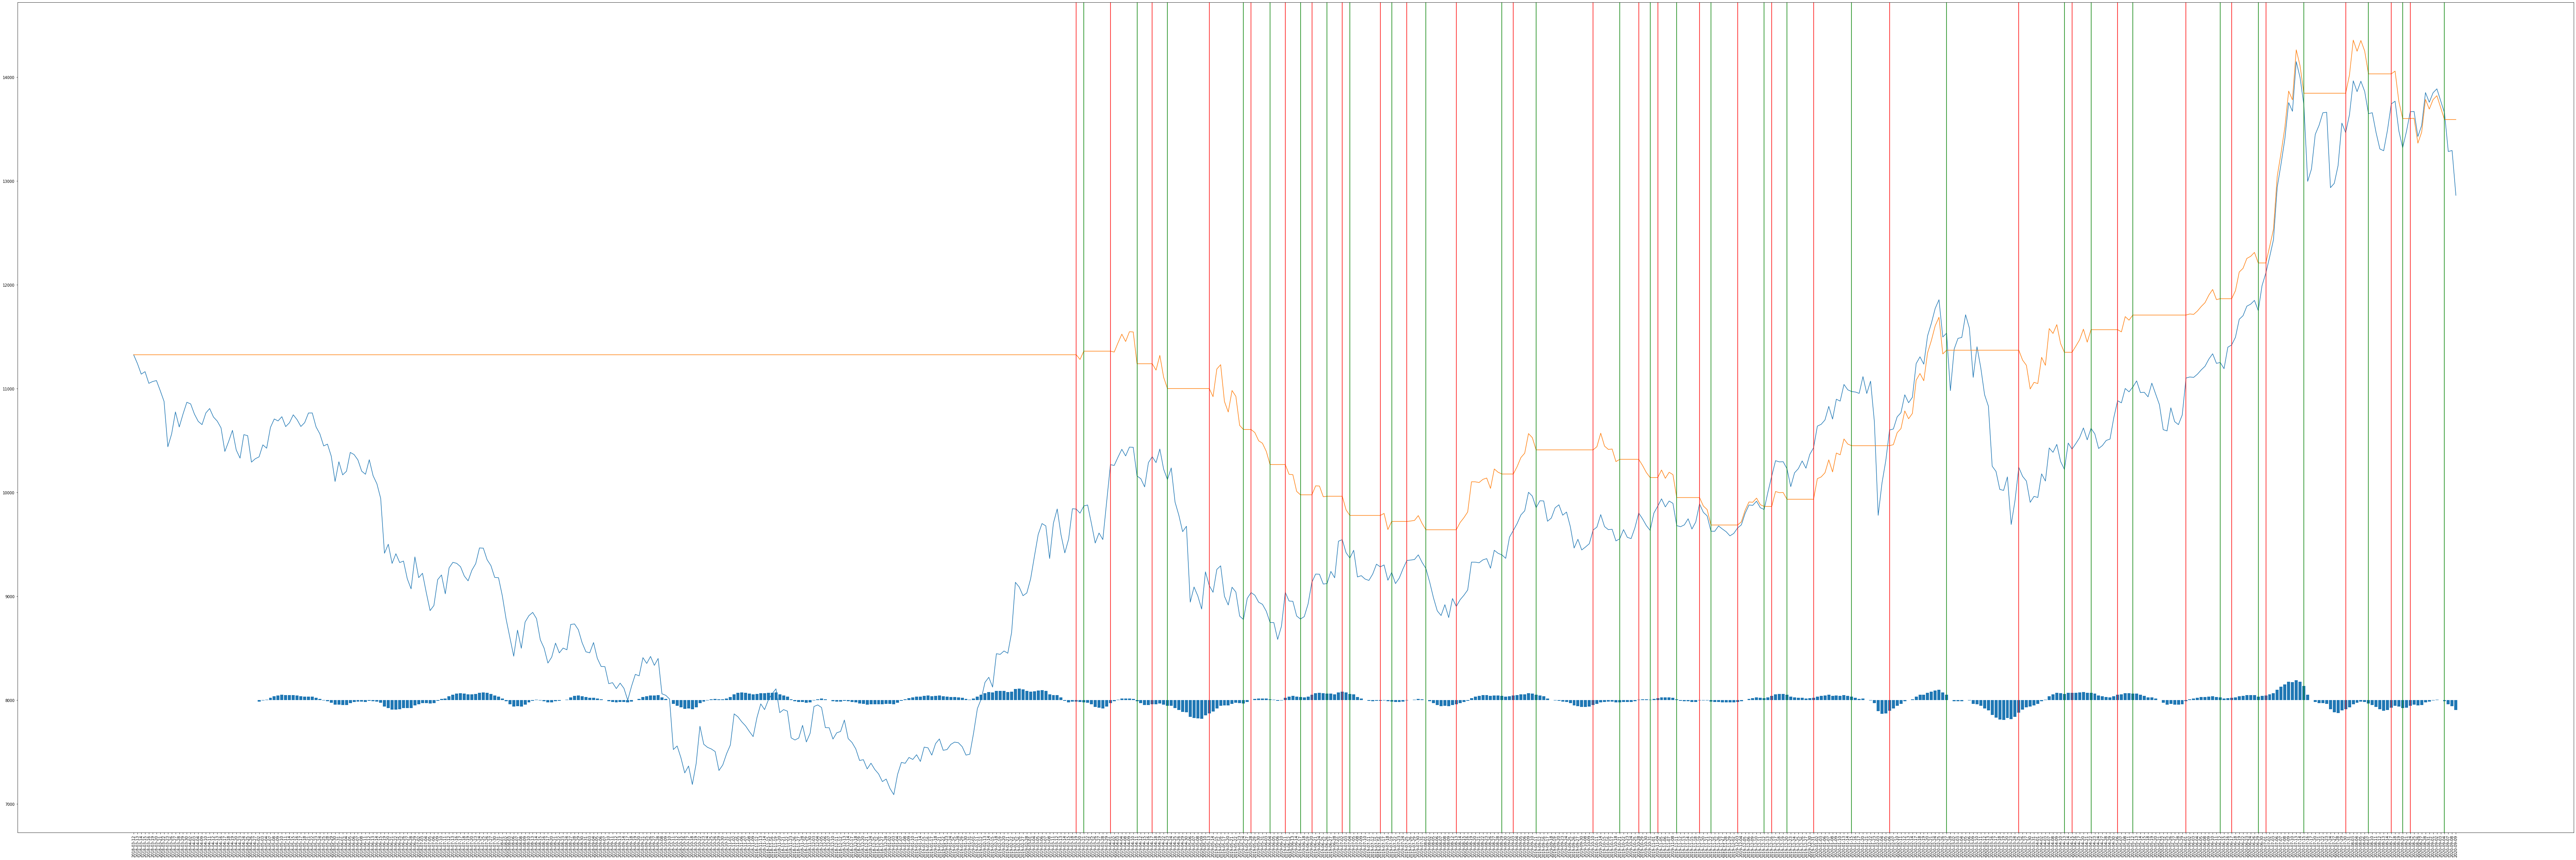

In [18]:
plt.figure(figsize=(120,40))
plt.bar(x= df1.index,height= df1['hist'],bottom=8000)
#plt.plot(df1['hist']+8000)
plt.plot(df1['close'])
plt.plot(df1['value'])
#plt.grid(color="k", linestyle=":")
plt.xticks(df1.index,df1['date'],rotation='vertical')
plt.savefig("test.png", dpi=120)
for xsr in sr:
    plt.axvline(x=xsr,c='green')
for xbr in br:
    plt.axvline(x=xbr,c='red')
plt.savefig('./hist.png')
plt.show()




In [19]:
end = df1.iloc[-1]['value']
start = df1.loc[0,'close']
benefit = end/start-1.0
market_benefit = df1.iloc[-1]['close']/start-1.0
print('The final reward of the strategy is %f %%'%((end/start-1.0)*100))
print('%f %% more than the market index.'%((benefit-market_benefit)*100))

The final reward of the strategy is 19.999901 %
6.443099 % more than the market index.


In [20]:
df1.to_csv('./game_data.csv')

In [21]:
datapath = './game_data.csv'
df1 = pd.read_csv(datapath)

best_buyprice = min(df1.loc[:,'close'])
best_sellprice = max(df1.loc[:,'close'])
trans = 10000/best_buyprice * best_sellprice
print(trans)


19958.050283238168


572     -3.66
573    114.94
574    448.85
575    536.17
576    657.03
577    661.50
578    -64.30
579    -23.13
580    147.35
581    557.44
582    466.85
583    637.88
584    964.56
585    860.46
586    960.92
587    863.13
588    648.50
589    657.31
590    466.27
591    308.52
592    291.32
593    489.01
594    742.23
595    768.17
596    480.85
597    320.92
598    478.00
599    666.69
600    669.41
601    428.40
602    535.09
603    851.32
604    758.23
605    849.66
606    887.43
607    772.37
608    656.66
609    284.03
610    293.33
611   -138.25
Name: close, dtype: float64
1200


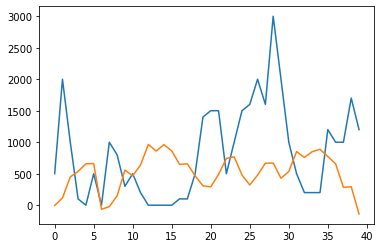

In [29]:
reverse_repo = [500,2000,1000,100,0,500,0,1000,800,300,500,200,0,0,0,0,100,100,500,1400,1500,1500,500,1000,1500,1600,2000,1600,3000,2000,1000,500,200,200,200,1200,1000,1000,1700,1200]
close = df1.loc[len(df1)-len(reverse_repo):len(df1)-1,'close']-13000
print(close)
a = close.tolist()
indexlist = [i for i in range(len(reverse_repo))]
plt.plot(indexlist,reverse_repo)
plt.plot(indexlist,a)
plt.show()
print(reverse_repo[-1])